In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("../data/train.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [6]:
import matplotlib.pyplot as plt

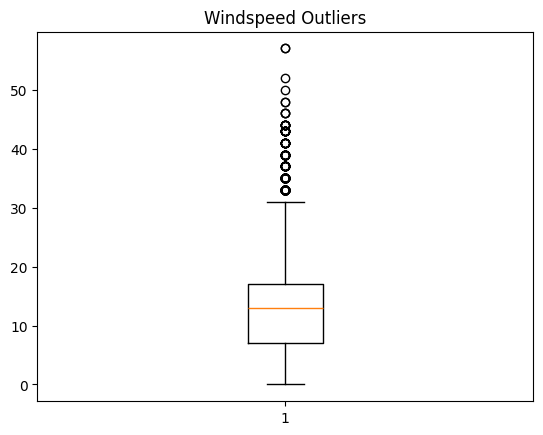

In [7]:
# Box plot to detect outliers in windspeed
plt.boxplot(data['windspeed'])
plt.title('Windspeed Outliers')
plt.show()
# Cap windspeed at a maximum threshold if necessary
data['windspeed'] = data['windspeed'].clip(upper=40)

In [10]:
data['is_clear_weather'] = (data['weather'] == 1).astype(int)

In [11]:
data['is_rainy_weather'] = (data['weather'] >= 3).astype(int)

In [12]:
# Create a combined feature for holidays and working days
data['is_holiday_workingday'] = ((data['holiday'] == 1) & (data['workingday'] == 1)).astype(int)

In [20]:
data.drop(columns=["datetime"], inplace=True)

In [14]:
from sklearn.model_selection import train_test_split

In [21]:
# Split the data into features and target
X = data.drop(columns=["count"])  # Features (all columns except 'count')
y = data["count"]  # Target variable
# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Verify the split
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (8708, 13)
Testing data size: (2178, 13)


In [16]:
import mlflow
import mlflow.sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Configure MLflow
mlflow.set_tracking_uri("http://98.81.184.50:5000/")
mlflow.set_experiment("RandomForest_Classification")

<Experiment: artifact_location='s3://mybucket-brunoroman/modelo/1', creation_time=1736882001682, experiment_id='1', last_update_time=1736882001682, lifecycle_stage='active', name='RandomForest_Classification', tags={}>

In [42]:
# Define the model
model = DecisionTreeRegressor(max_depth=10, random_state=42)
# Start an MLFlow run
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model_type", "DecisionTreeRegressor")
    mlflow.log_param("max_depth", 10)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    # Log evaluation metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    
    # Plot and log feature importance as an artifact
    feature_importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(X_train.columns, feature_importances)
    plt.title("Feature Importance")
    plt.savefig("feature_importance.png")
    
    # Log the artifact (the feature importance plot)
    mlflow.log_artifact("feature_importance.png")
    
    # Log the model itself
    mlflow.sklearn.log_model(model, "model")
    
print(f"Model training complete. MAE: {mae}, RMSE: {rmse}")

MlflowException: API request to http://98.81.184.50:5000/api/2.0/mlflow/runs/create failed with timeout exception HTTPConnectionPool(host='98.81.184.50', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x000002659DE8DB50>, 'Connection to 98.81.184.50 timed out. (connect timeout=120)')). To increase the timeout, set the environment variable MLFLOW_HTTP_REQUEST_TIMEOUT (default: 120, type: int) to a larger value.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import mlflow
import mlflow.sklearn

In [24]:
# Define the model and the hyperparameter grid
model = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20]
}
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
# Start an MLFlow run for hyperparameter tuning
with mlflow.start_run():
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Log the best hyperparameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("best_min_samples_split", best_params['min_samples_split'])
    
    # Log the best score (cross-validated)
    best_score = -grid_search.best_score_  # Convert to positive since we used neg_mean_squared_error
    mlflow.log_metric("best_cross_val_score", best_score)
    
    # Log the final model
    best_model = grid_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")
    
    # Evaluate the model on the test set and log the result
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)
    
print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025/01/14 16:39:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bouncy-deer-695 at: http://98.81.184.50:5000/#/experiments/1/runs/5687b05894d244a4a0f1dcfe66af1591
🧪 View experiment at: http://98.81.184.50:5000/#/experiments/1
Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 2}
Test RMSE: 5.382411790708831


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [26]:
# Define the hyperparameter distributions
param_distributions = {
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 20)
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, 
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=1)
# Perform RandomizedSearchCV with MLFlow tracking
with mlflow.start_run():
    random_search.fit(X_train, y_train)
    
    # Log the best hyperparameters and metrics
    best_params = random_search.best_params_
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("best_min_samples_split", best_params['min_samples_split'])
    
    best_score = -random_search.best_score_  # Convert to positive MSE
    mlflow.log_metric("best_cross_val_score", best_score)
    
    # Log the best model
    best_model = random_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")
    
    # Evaluate and log test set performance
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)
print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


2025/01/14 16:41:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run upbeat-colt-222 at: http://98.81.184.50:5000/#/experiments/1/runs/713bf0b2f5e041c7b4d726fedd644d1a
🧪 View experiment at: http://98.81.184.50:5000/#/experiments/1
Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 5}
Test RMSE: 5.255332430321498


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow

In [28]:
# Evaluate the model
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [29]:
# Log the metrics using MLFlow
with mlflow.start_run():
    mlflow.log_metric("R2", r2)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)

🏃 View run classy-fowl-80 at: http://98.81.184.50:5000/#/experiments/1/runs/89740a12f2914769a39dc60e3a8eefb3
🧪 View experiment at: http://98.81.184.50:5000/#/experiments/1


In [30]:
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

R²: 0.999
RMSE: 5.255
MAE: 2.641


In [31]:
import mlflow
import mlflow.sklearn

In [34]:
# Save the best model using MLFlow
with mlflow.start_run() as run:
    # Take the first row of the training dataset as the model input example.
    input_example = X_train.iloc[[0]]
    # The signature is automatically inferred from the input example and its predicted output.
    mlflow.sklearn.log_model(best_model, "bike_prediction_model", input_example=input_example)
    print("Model saved successfully!")
    # Register the model in the model registry
    model_uri = f"runs:/{run.info.run_id}/bike_prediction_model"
    mlflow.register_model(model_uri, "BikePredictionModel")

c:\Users\bruno\Documents\curso github actions\projeto-mlops-bike\.venv\Lib\site-packages\mlflow\types\utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Model saved successfully!


Successfully registered model 'BikePredictionModel'.
2025/01/14 16:55:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BikePredictionModel, version 1
Created version '1' of model 'BikePredictionModel'.


🏃 View run thundering-shoat-424 at: http://98.81.184.50:5000/#/experiments/1/runs/2c0933594ad84a1c813a00e5b00c9704
🧪 View experiment at: http://98.81.184.50:5000/#/experiments/1


In [35]:
from mlflow.tracking import MlflowClient

In [36]:
client = MlflowClient()

In [37]:
# Transition the model to staging
client.transition_model_version_stage(
    name="BikePredictionModel",
    version=1,
    stage="Staging"
)

C:\Users\bruno\AppData\Local\Temp\ipykernel_23256\3856255095.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1736884509392, current_stage='Staging', description='', last_updated_timestamp=1736884627674, name='BikePredictionModel', run_id='2c0933594ad84a1c813a00e5b00c9704', run_link='', source='s3://mybucket-brunoroman/modelo/1/2c0933594ad84a1c813a00e5b00c9704/artifacts/bike_prediction_model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [38]:
# After testing, promote the model to production
client.transition_model_version_stage(
    name="BikePredictionModel",
    version=1,
    stage="Production"
)

C:\Users\bruno\AppData\Local\Temp\ipykernel_23256\2851648371.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1736884509392, current_stage='Production', description='', last_updated_timestamp=1736884721558, name='BikePredictionModel', run_id='2c0933594ad84a1c813a00e5b00c9704', run_link='', source='s3://mybucket-brunoroman/modelo/1/2c0933594ad84a1c813a00e5b00c9704/artifacts/bike_prediction_model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [39]:
# List all versions of the registered model
model_versions = client.search_model_versions("name='BikePredictionModel'")
for version in model_versions:
    print(f"Version: {version.version}, Stage: {version.current_stage}")

Version: 1, Stage: Production


In [40]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [41]:
def retrain_model(new_data):
    # Load new dataset
    X = new_data.drop(columns=["target"])
    y = new_data["target"]
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train a new model (e.g., Linear Regression)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Log the retrained model and metrics with MLFlow
    with mlflow.start_run():
        mlflow.sklearn.log_model(model, "retrained_bike_prediction_model")
        # Log metrics like R² and RMSE
        predictions = model.predict(X_test)
        r2_score = model.score(X_test, y_test)
        mlflow.log_metric("r2_score", r2_score)
        # Add more metrics and artifacts as needed
        
    print(f"Retrained model logged with R²: {r2_score}")